In [1]:
!pip install pyspark


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install pyarrow


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pandas as pd
import pyarrow as pa


In [38]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("example") \
    .getOrCreate()


In [7]:
from pyspark.sql import SparkSession
import pyspark.pandas
import pandas as pd
from pyspark.sql.types import IntegerType
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql import types 
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import date_format
from pyspark.sql.types import DateType
from pyspark.sql.functions import quarter
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import hour, col
from pyspark.sql.functions import when
import statsmodels
from statsmodels.tsa.stattools import coint
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px



C:\Users\AC\anaconda3\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
C:\Users\AC\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
!pip install pyspark findspark

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("example") \
    .getOrCreate()



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.master("local[*]").config("spark.memory.offHeap.enabled", "true").config("spark.memory.offHeap.size", "10g").getOrCreate()

# Import datasets
df_pr_co = spark.read.csv(r"C:\Users\AC\OneDrive\Desktop\projects and paper\e-commerce-analysis-university-project-main\prices_competitor.csv", header=True, inferSchema=True)
df_pr_ca = spark.read.csv(r"C:\Users\AC\OneDrive\Desktop\projects and paper\e-commerce-analysis-university-project-main\product_catalog.csv", header=True, inferSchema=True)


# DATA MANIPOULATION: Brief EDA and dataset merging

## PRODUCT CATALOG

In [2]:
df_pr_ca.show(5)

+----------+----------+----------+----------+-----------+----------+
|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+----------+----------+----------+-----------+----------+
|    143226|      2259|      1412|      1412|        522|      2719|
|    106100|      2880|      2856|      1169|        309|      1937|
|    149306|      2880|      2856|      4877|        455|      3618|
|    160649|       624|      2291|       601|        543|      2194|
|    124455|      1676|      2193|      2409|        289|      3120|
+----------+----------+----------+----------+-----------+----------+
only showing top 5 rows



In [3]:
# check the lengh of the dataset
print((df_pr_ca.count(), len(df_pr_ca.columns)))


(50, 6)


In [4]:
df_pr_ca.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)



In [13]:
from pyspark.sql.functions import col, when, count, isnan

null_df = df_pr_ca.select([
    count(when(
        (col(c) == '') |
        col(c).isNull() |
        isnan(c), c
    )).alias(c)
    for c in df_pr_ca.columns
])

null_df.show()


+----------+----------+----------+----------+-----------+----------+
|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+----------+----------+----------+-----------+----------+
|         0|         0|         0|         0|          0|         0|
+----------+----------+----------+----------+-----------+----------+



## PRICES COMPETITOR

In [14]:
df_pr_co.show()

+----------+---------+----------+-----+
| comp_date|seller_id|product_id|price|
+----------+---------+----------+-----+
|2021-01-01|       23|    112437| 7999|
|2021-01-01|       24|    112437| 8499|
|2021-01-01|       26|    112437| 6990|
|2021-01-01|       41|    112437| 7400|
|2021-01-01|       48|    112437| 8499|
|2021-01-01|      180|    112437| 7299|
|2021-01-01|      188|    112437| 7490|
|2021-01-01|       23|    110675| 3599|
|2021-01-01|       24|    110675| 3649|
|2021-01-01|       26|    110675| 3649|
|2021-01-01|       41|    110675| 2790|
|2021-01-01|       48|    110675| 3649|
|2021-01-01|      180|    110675| 3490|
|2021-01-01|      188|    110675| 3690|
|2021-01-01|      407|    110675| 2690|
|2021-01-01|       23|    103851| 1190|
|2021-01-01|       24|    103851| 1190|
|2021-01-01|       26|    103851| 1190|
|2021-01-01|       48|    103851| 1190|
|2021-01-01|      180|    103851| 1099|
+----------+---------+----------+-----+
only showing top 20 rows



In [15]:
# check the lengh of the dataset
print((df_pr_co.count(), len(df_pr_co.columns)))


(82865, 4)


In [16]:
df_pr_co.printSchema()

root
 |-- comp_date: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: integer (nullable = true)



In [17]:
from pyspark.sql.types import StringType

# Convert the 'comp_date' column to StringType
df_pr_co = df_pr_co.withColumn("comp_date", df_pr_co["comp_date"].cast(StringType()))


In [18]:

# checking for null values

null_df = df_pr_co.select([count(when(col(c).contains('None') |\
                        col(c).contains('NULL')|\
                        (col(c) == '')|\
                        col(c).isNull() |\
                        isnan(c), c
                          )).alias(c)
                        for c in df_pr_co.columns])

null_df.show()

+---------+---------+----------+-----+
|comp_date|seller_id|product_id|price|
+---------+---------+----------+-----+
|        0|        0|         0|    0|
+---------+---------+----------+-----+



## JOIN

In [19]:
df = df_pr_co.join(df_pr_ca,df_pr_co.product_id ==  df_pr_ca.product_id,"inner")
df.show(5)

+----------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+
| comp_date|seller_id|product_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+
|2021-01-01|       23|    112437| 7999|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       24|    112437| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       26|    112437| 6990|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       41|    112437| 7400|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       48|    112437| 8499|    112437|      2259|       944|      1763|        542|      3142|
+----------+---------+----------+-----+----------+----------+----------+----------+-----------+----------+
only showing top 5 rows



In [20]:
df.printSchema()

root
 |-- comp_date: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)



In [21]:
#checking lenght of the dataset for the data consistency of the inner join
print((df.count(), len(df.columns)))
print((df_pr_co.count(), len(df_pr_co.columns)))



(82865, 10)
(82865, 4)


the longest dataset (prices competitor) of the join operation is of the same lenght of the new df.

## more data modelling on the final dataset

In [23]:
from pyspark.sql.types import DateType

# Cleaning date column and converting it to DateType format
df_pr_co = df_pr_co.withColumn("comp_date", df_pr_co["comp_date"].cast(DateType()))


In [24]:
df.printSchema()

root
 |-- comp_date: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)



In [25]:
# Create five different time intervals with quartiles. This is fundamental to have a more precise picture of the situation. The intervals are:
# first quarter : from January to March
# second quarter: from April to June
# third quarter : from July to September
# fourth quarter : from October to December

df = df.withColumn('quarter',quarter(df.comp_date))
black_friday = df.filter(F.col("comp_date").between(pd.to_datetime('2021-11-01'),pd.to_datetime('2021-11-30')))
df.show()

NameError: name 'quarter' is not defined

In [26]:
# remove duplicate product_id column

df_cols = df.columns
# get index of the duplicate columns
duplicate_col_index = list(set([df_cols.index(c) for c in df_cols if df_cols.count(c) == 2]))

# rename by adding suffix '_duplicated'
for i in duplicate_col_index:
    df_cols[i] = df_cols[i] + '_duplicated'

# rename the column in DF
df = df.toDF(*df_cols)

# remove flagged columns
cols_to_remove = [c for c in df_cols if '_duplicated' in c]
df =  df.drop(*cols_to_remove)
df.show()

+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
| comp_date|seller_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
|2021-01-01|       23| 7999|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       24| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       26| 6990|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       41| 7400|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       48| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|      180| 7299|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|      188| 7490|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       23| 3599|    110675| 

In [27]:
# filtered the dataset in order to consider only the product sold by seller 24

df_24 = df.filter(df.seller_id == 24)
df_24.show(5)


+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
| comp_date|seller_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
|2021-01-01|       24| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       24| 3649|    110675|      2180|       613|      2275|        544|      2531|
|2021-01-01|       24| 1190|    103851|      2259|       944|      1867|        367|      2979|
|2021-01-01|       24| 3990|    107645|      2259|      1714|       720|        522|      1782|
|2021-01-01|       24| 3990|    110853|      2259|      2015|       493|        522|      1709|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
only showing top 5 rows



In [28]:
len_df = df.count()
print("Number of items in the dataset", len_df)

len_24 = df_24.count()
print("Number of product 24 item in the dataset", len_24)

print("Our market share is" ,(len_24/len_df) )


Number of items in the dataset 82865
Number of product 24 item in the dataset 14945
Our market share is 0.1803535871598383


In [29]:
# most presesent seller in the dataset

market_share = df.groupBy('seller_id').count()
market_share = market_share.withColumn("market_share", market_share["count"]/len_df)
market_share.show()

+---------+-----+-------------------+
|seller_id|count|       market_share|
+---------+-----+-------------------+
|       26|13374|0.16139504012550535|
|       48|12577|0.15177698666505762|
|       41| 9159|0.11052917395764195|
|       23| 6396|0.07718578410667953|
|       24|14945| 0.1803535871598383|
|      490| 3980|0.04802992819646413|
|      188| 6452|0.07786158209135341|
|      180| 8746|0.10554516382067218|
|      407| 7236|0.08732275387678755|
+---------+-----+-------------------+



# Business analysis

## Which are the top sold 10 products ?
In order to understand the leaders and the followers for the key products sold by retailer 24, we investigate about the top 10 products sold by him and compared dinamicaly their pricece with the ones of all the other main competitors

In [44]:
# Place your file in a simple path like C:\data\yourfile.csv
df_sd = spark.read.csv(r"C:\Users\AC\OneDrive\Desktop\projects and paper\e-commerce-analysis-university-project-main\sales_data.csv", header=True, inferSchema=True)

df_sd.show()


+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+
| sale_date|product_id|quantity|sales_price_tax|regular_price_tax|sales_price|regular_price|purchase_price|
+----------+----------+--------+---------------+-----------------+-----------+-------------+--------------+
|2021-01-02|    110853|       1|         3990.0|           8322.0|     3325.0|    6935.1852|        2833.7|
|2021-01-03|    157318|       1|         4590.0|          12211.0|     3825.0|   10175.9259|        3481.2|
|2021-01-04|    107645|       3|         1990.0|           4433.0|     1658.0|    3694.4444|       1369.29|
|2021-01-04|    110853|      12|         3990.0|           8322.0|     3325.0|    6935.1852|        2833.7|
|2021-01-04|    110908|       1|         4490.0|           7767.0|     3742.0|    6472.2222|        3722.0|
|2021-01-04|    112376|       3|          379.0|            544.0|      316.0|     453.7037|        168.97|
|2021-01-04|    112377|     

In [46]:
# cleaning date column

df_sd = df_sd.withColumn("comp_date",df_sd['sale_date'].cast(DateType()))

In [47]:
# the most common item for seller 24
top_sell = df_sd.groupBy("product_id").count().orderBy(col('count').desc())
top_sell.show()


+----------+-----+
|product_id|count|
+----------+-----+
|    157318|  210|
|    107645|  185|
|    157317|  184|
|    103851|  179|
|    125506|  171|
|    128772|  168|
|    132284|  167|
|    112377|  162|
|    157316|  161|
|    134358|  155|
|    143220|  154|
|    110908|  154|
|    132842|  151|
|    134200|  147|
|    132408|  145|
|    154557|  145|
|    133888|  140|
|    154553|  131|
|    163385|  126|
|    161147|  125|
+----------+-----+
only showing top 20 rows



In [49]:

# param= {
#     "price":"mean",
#     "coded_cat1":"first",
#     "coded_cat2":"first",
#     "coded_cat3":"first",
#     "coded_brand":"first",
#     "coded_name":"first",
#     "quarter":"first",
# }

# df_grouped = df_24.groupby(["comp_date","seller_id","product_id"]).agg(param)

# Updated aggregation parameters based on available columns
param = {
    "price": "mean",
    "coded_cat1": "first",
    "coded_cat2": "first",
    "coded_cat3": "first",
    "coded_brand": "first",
    "coded_name": "first"
}

# Perform the groupby and aggregation
df_grouped = df_24.groupby(["comp_date", "seller_id", "product_id"]).agg(param)

# Show the resulting DataFrame
df_grouped.show()



+----------+---------+----------+-----------------+----------+-----------------+-----------------+------------------+-----------------+
| comp_date|seller_id|product_id|first(coded_name)|avg(price)|first(coded_cat1)|first(coded_cat2)|first(coded_brand)|first(coded_cat3)|
+----------+---------+----------+-----------------+----------+-----------------+-----------------+------------------+-----------------+
|2021-01-04|       24|    132408|             2720|   11999.0|             2259|              944|               367|             1753|
|2021-01-10|       24|    112437|             3142|    7999.0|             2259|              944|               542|             1763|
|2021-01-14|       24|    149306|             3618|   20440.0|             2880|             2856|               455|             4877|
|2021-01-27|       24|    142254|             2524|    5990.0|             2259|              944|               253|             1763|
|2021-01-30|       24|    154557|             28

## understand price relationship

In [50]:
df.show()

+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
| comp_date|seller_id|price|product_id|coded_cat1|coded_cat2|coded_cat3|coded_brand|coded_name|
+----------+---------+-----+----------+----------+----------+----------+-----------+----------+
|2021-01-01|       23| 7999|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       24| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       26| 6990|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       41| 7400|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       48| 8499|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|      180| 7299|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|      188| 7490|    112437|      2259|       944|      1763|        542|      3142|
|2021-01-01|       23| 3599|    110675| 

In [58]:
df.printSchema()


root
 |-- comp_date: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- coded_cat1: integer (nullable = true)
 |-- coded_cat2: integer (nullable = true)
 |-- coded_cat3: integer (nullable = true)
 |-- coded_brand: integer (nullable = true)
 |-- coded_name: integer (nullable = true)
 |-- BLACKFRIDAY: string (nullable = false)



In [59]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from datetime import datetime

# Initialize SparkSession if not already done
spark = SparkSession.builder.appName("ProductPriceAnalysis").getOrCreate()

# Assuming 'df' is already loaded as a DataFrame
# df = spark.read.csv("path/to/your/data.csv", header=True, inferSchema=True)

# Choose the product to analyze
product = 107645

# Add BLACKFRIDAY column based on date range
df = df.withColumn(
    'BLACKFRIDAY',
    F.when(
        (F.col('comp_date').between(datetime(2021, 11, 1), datetime(2021, 11, 30))),
        "Yes"
    ).otherwise("No")
)

# Filter DataFrame for the chosen product
df_final_product = df.filter(F.col('product_id') == product)

# Pivot DataFrame to get the maximum price for each seller by date
df_final_product = df_final_product.groupBy("comp_date") \
                                    .pivot("seller_id") \
                                    .agg(F.max("price")) \
                                    .sort("comp_date") \
                                    .fillna(0)

# Show the resulting DataFrame
df_final_product.show()


+----------+----+----+----+----+----+----+----+----+---+
| comp_date|  23|  24|  26|  41|  48| 180| 188| 407|490|
+----------+----+----+----+----+----+----+----+----+---+
|2021-01-01|1999|3990|3990|1750|3990|1779|1990|2299|  0|
|2021-01-02|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-03|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-04|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-05|1999|1990|3990|1750|1990|1899|1990|2299|  0|
|2021-01-06|1999|1990|1990|1750|1990|1899|1990|2299|  0|
|2021-01-07|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-08|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-09|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-10|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-11|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-12|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-13|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-14|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-15|1999|1990|1990|1990

In [60]:
df = df.withColumn('comp_date', F.to_date(F.col('comp_date'), 'yyyy-MM-dd'))


In [62]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Define the window specification
w = Window().partitionBy().orderBy(F.col("comp_date"))

# List of columns to shift
valueColumns = ['23', '24', '26', '41', '48', '180', '188', '407', '490']

# Shift all rows down by 1
df_final_product_shift = df_final_product.select(
    "comp_date",
    *[F.lag(c, offset=1).over(w).alias(c) for c in valueColumns]
).dropna(how="any")

# Show the resulting DataFrame
df_final_product_shift.show()


+----------+----+----+----+----+----+----+----+----+---+
| comp_date|  23|  24|  26|  41|  48| 180| 188| 407|490|
+----------+----+----+----+----+----+----+----+----+---+
|2021-01-02|1999|3990|3990|1750|3990|1779|1990|2299|  0|
|2021-01-03|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-04|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-05|1999|3990|3990|1750|3990|1899|1990|2299|  0|
|2021-01-06|1999|1990|3990|1750|1990|1899|1990|2299|  0|
|2021-01-07|1999|1990|1990|1750|1990|1899|1990|2299|  0|
|2021-01-08|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-09|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-10|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-11|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-12|1999|1990|1990|1750|1990|1890|1990|2299|  0|
|2021-01-13|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-14|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-15|1999|1990|1990|1990|1990|1890|1990|2299|  0|
|2021-01-16|1999|1990|1990|1990

In [63]:
# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


In [64]:
# converting spark df to pandas for data visualization

pandasDF = df_final_product.toPandas()
pandasDF_shifted = df_final_product_shift.toPandas()
pandasDF_grouped = df_grouped.toPandas()
df_final_pd = df.toPandas()



In [65]:
# rename the column

dict2 = {'first(coded_name)': 'coded_name',
        'avg(price)': 'price',
        'first(coded_cat1)': 'coded_cat1',
        'first(quarter)': 'quarter',
        'first(coded_cat2)': 'coded_cat2',
        'first(coded_brand)': 'coded_brand',
        'first(coded_cat3)': 'coded_cat3'
        }

pandasDF_grouped.rename(columns=dict2,inplace=True)

In [68]:
#date format conversion

import pandas as pd
date_conversion = pd.to_datetime(pandasDF['comp_date'], format='%Y-%m-%d')
date_conversion2 = pd.to_datetime(pandasDF_shifted['comp_date'], format='%Y-%m-%d')
pandasDF['comp_date'] = date_conversion
pandasDF_shifted['comp_date'] = date_conversion2
pandasDF = pandasDF[1:]

In [69]:
# new index

pandasDF = pandasDF.set_index('comp_date')
pandasDF_shifted = pandasDF_shifted.set_index("comp_date")


In [72]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint

# Lists to store results
my_list = []
Leader = []
Follower = []
Cointegration = []
Beta = []

# Ensure that both DataFrames have the same index
pandasDF = pandasDF.reset_index(drop=True)
pandasDF_shifted = pandasDF_shifted.reset_index(drop=True)

# Loop through columns to find correlations, cointegration, and beta
for i in pandasDF_shifted.columns:
    for j in pandasDF_shifted.columns:
        if i != j:
            # Calculate correlation
            corr_value = pandasDF[i].corr(pandasDF_shifted[j])
            if corr_value:
                Leader.append(j)
                Follower.append(i)
                my_list.append(corr_value)
                
                # Handle alignment and missing values
                df_combined = pd.DataFrame({i: pandasDF[i], j: pandasDF_shifted[j]})
                df_combined = df_combined.dropna()  # Drop rows with missing values
                
                if len(df_combined) > 1:  # Ensure enough data for cointegration test
                    # Calculate cointegration p-value
                    coint_result = coint(df_combined[j], df_combined[i])
                    Cointegration.append(coint_result[1])
                    
                    # Calculate Beta using least squares
                    beta = np.linalg.lstsq(df_combined[i].values[:, np.newaxis], df_combined[j].values, rcond=None)[0][0]
                    Beta.append(beta)
                else:
                    Cointegration.append(np.nan)
                    Beta.append(np.nan)

# Create a DataFrame with the results
output = pd.DataFrame({
    'Leader': Leader,
    'Follower': Follower,
    'Value': my_list,
    'Cointegration': Cointegration,
    'Beta': Beta
})

# Sort the results by the 'Value' column
sample = output.sort_values(by="Value", ascending=False)

# Display the sorted results
print(sample)


   Leader Follower     Value  Cointegration      Beta
53    180      188  0.906728   7.760461e-17  0.941325
45    188      180  0.854665   6.240096e-08  1.041936
40     23      180  0.648285   2.208489e-01  0.931458
4     180       23  0.617270   2.421802e-01  0.942573
48     23      188  0.613404   3.943771e-01  0.878349
..    ...      ...       ...            ...       ...
28    180       41 -0.316060   9.359513e-01  0.871092
71    407      490 -0.316262   6.316817e-06  0.878383
43     41      180 -0.347390   5.714038e-02  0.969426
2      41       23 -0.436868   1.519066e-01  0.907152
24     23       41 -0.447742   9.749614e-01  0.798612

[72 rows x 5 columns]


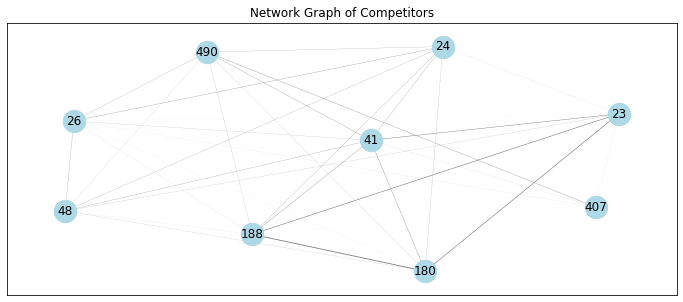

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Create the network graph from the DataFrame
G = nx.from_pandas_edgelist(sample, 'Leader', 'Follower', edge_attr='Value')

# Extract edge weights for the widths of edges
durations = [data['Value'] for _, _, data in G.edges(data=True)]

# Extract labels for the nodes
labels = {node: node for node in G.nodes()}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 5))
pos = nx.spring_layout(G)  # Position nodes using the spring layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color='lightblue')

# Draw edges with widths proportional to edge weights
nx.draw_networkx_edges(G, pos, width=durations, edge_color='gray', ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, labels, ax=ax)

# Set plot title and show plot
plt.title('Network Graph of Competitors')
plt.show()


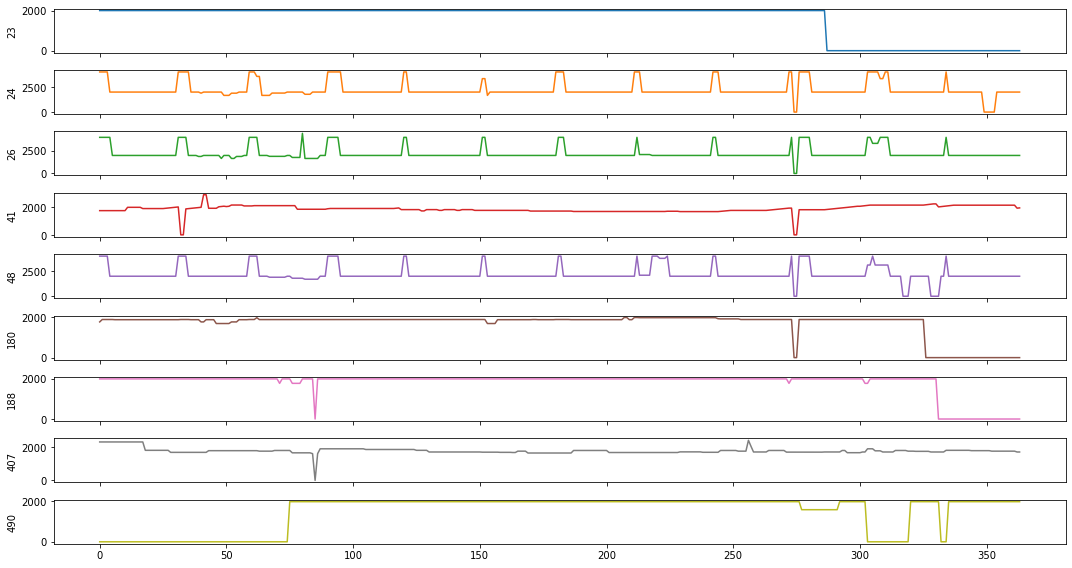

In [75]:
fig,ax = plt.subplots(len(pandasDF_shifted.columns), figsize=(15,8), sharex=True)

plot_cols = pandasDF_shifted.columns

pandasDF_shifted[plot_cols].plot(subplots=True, legend=False, ax=ax)

for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

In [76]:
from statsmodels.tsa.stattools  import   grangercausalitytests
grangercausalitytests(pandasDF_shifted[["26","24"]], maxlag=7) 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.8109 , p=0.0000  , df_denom=360, df_num=1
ssr based chi2 test:   chi2=23.0010 , p=0.0000  , df=1
likelihood ratio test: chi2=22.3016 , p=0.0000  , df=1
parameter F test:         F=22.8109 , p=0.0000  , df_denom=360, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.5291 , p=0.0000  , df_denom=357, df_num=2
ssr based chi2 test:   chi2=41.6333 , p=0.0000  , df=2
likelihood ratio test: chi2=39.4082 , p=0.0000  , df=2
parameter F test:         F=20.5291 , p=0.0000  , df_denom=357, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.9456 , p=0.0000  , df_denom=354, df_num=3
ssr based chi2 test:   chi2=48.7826 , p=0.0000  , df=3
likelihood ratio test: chi2=45.7564 , p=0.0000  , df=3
parameter F test:         F=15.9456 , p=0.0000  , df_denom=354, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.1465 , p=0.0000  

{1: ({'ssr_ftest': (22.810871204677287, 2.60596928960839e-06, 360.0, 1),
   'ssr_chi2test': (23.000961798049598, 1.6192037035541693e-06, 1),
   'lrtest': (22.30164076530582, 2.330074331280653e-06, 1),
   'params_ftest': (22.81087120463816, 2.6059692896583475e-06, 360.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (20.529122434026608, 3.637510315205409e-09, 357.0, 2),
   'ssr_chi2test': (41.63329031438449, 9.108479316983338e-10, 2),
   'lrtest': (39.408245520750825, 2.7708193663101773e-09, 2),
   'params_ftest': (20.529122433961277, 3.6375103154185613e-09, 357.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (15.945574064127259, 9.566932300563066e-10, 354.0, 3),
   'ssr_chi2test': (48.78264607754188, 1.4511072231821402e-10, 3),
   'lrtest': (45.75636346931606, 6.389927865773075e-10, 3),
   'params_ftest': (15.9455740641282, 9.566932300551341e-10, 354.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1.,

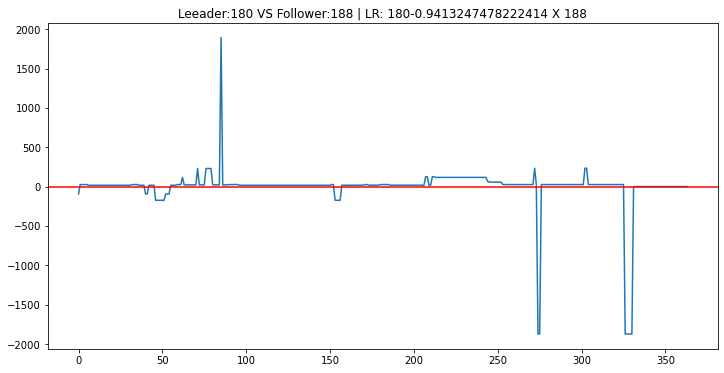

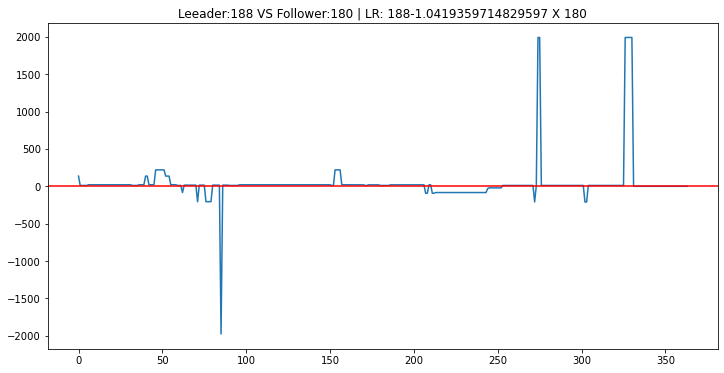

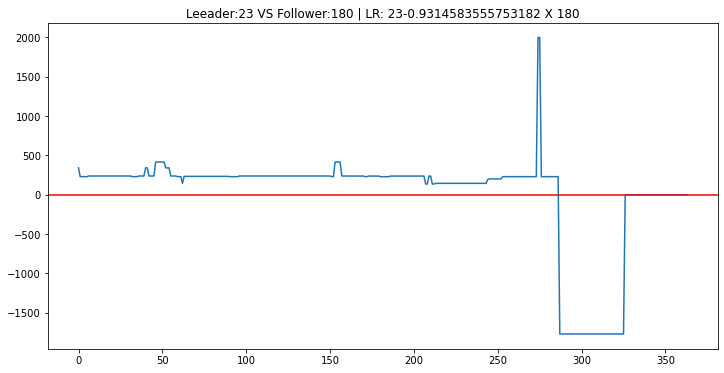

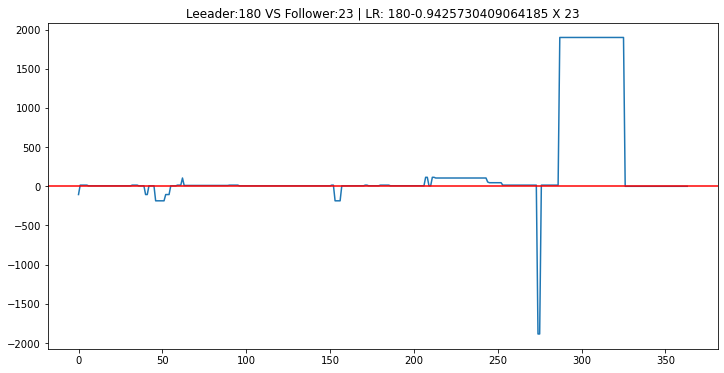

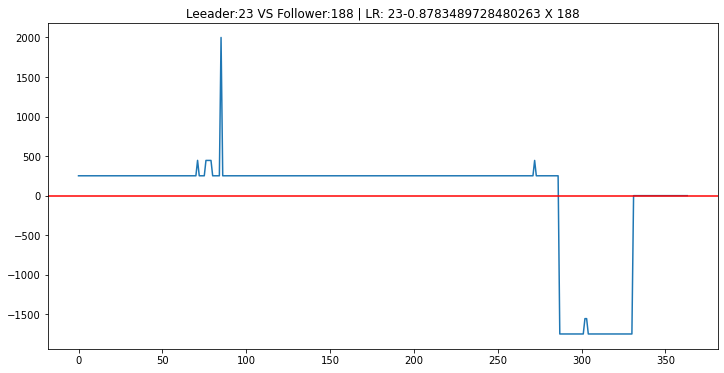

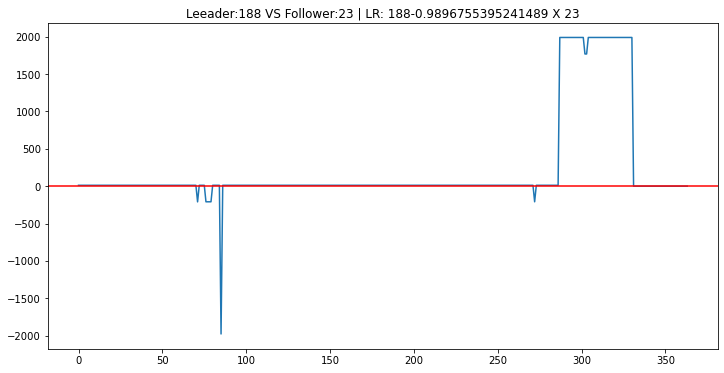

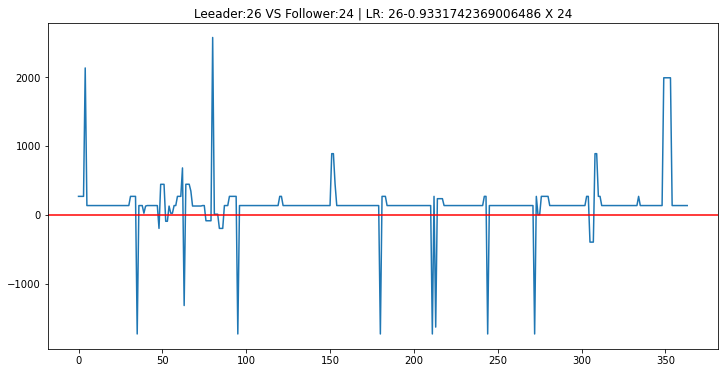

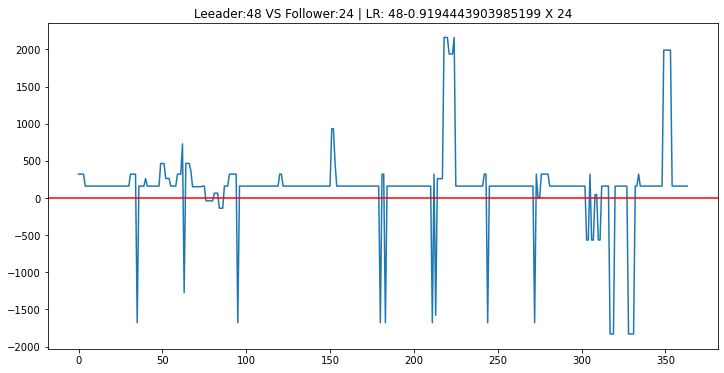

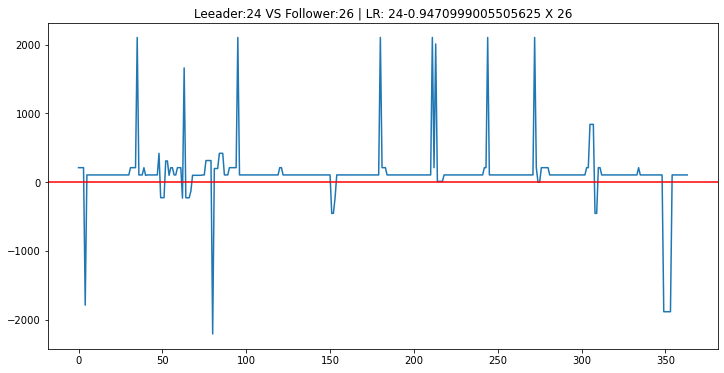

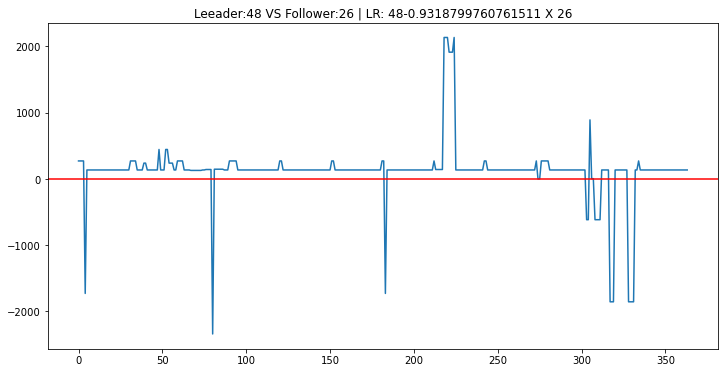

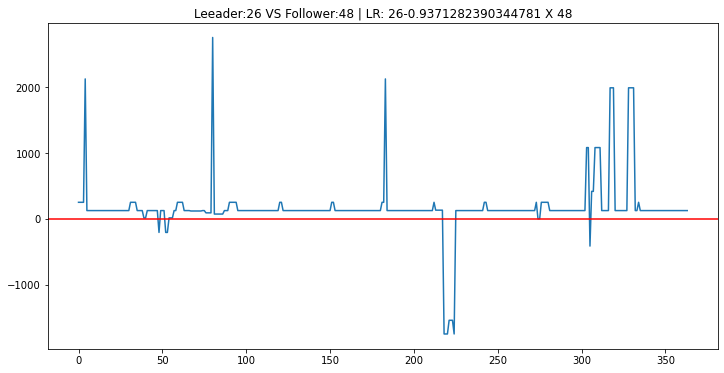

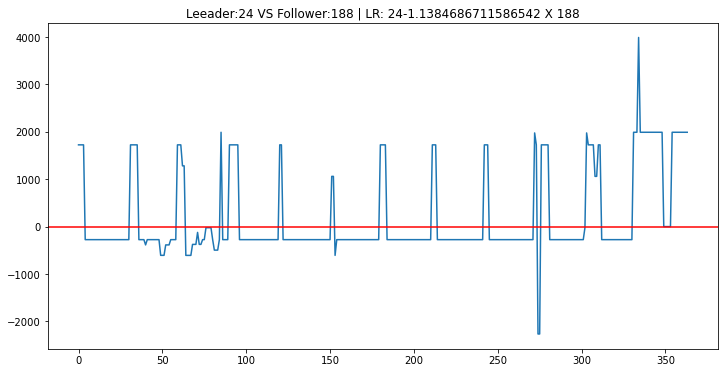

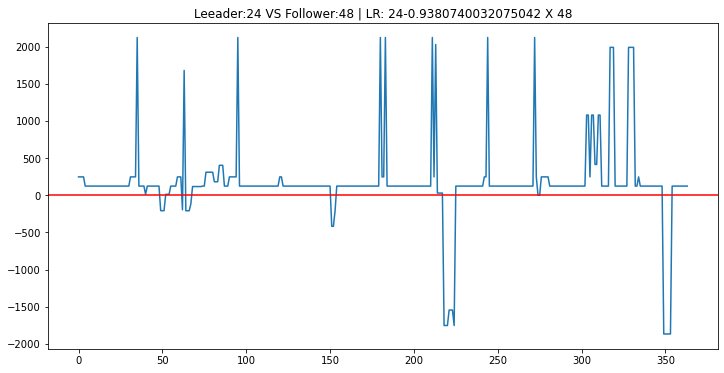

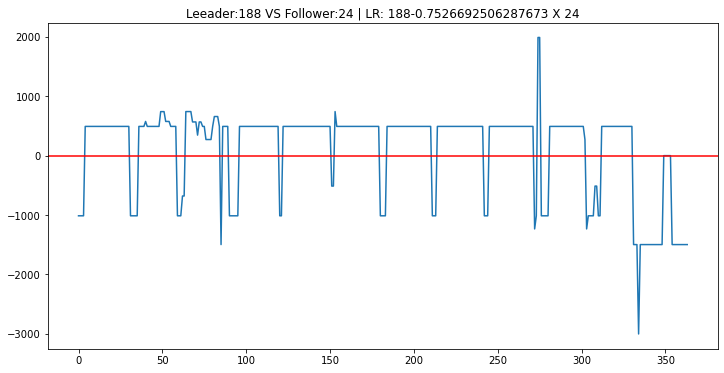

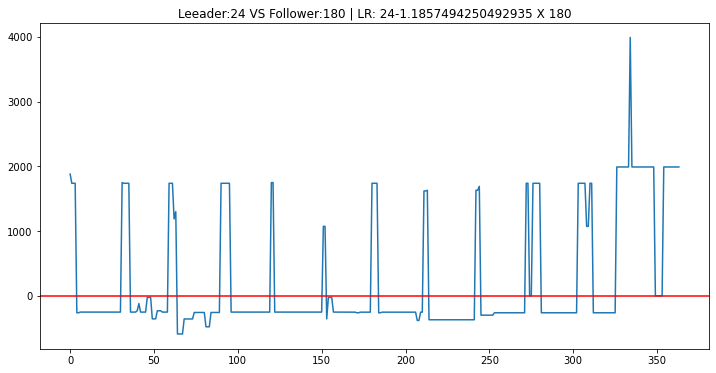

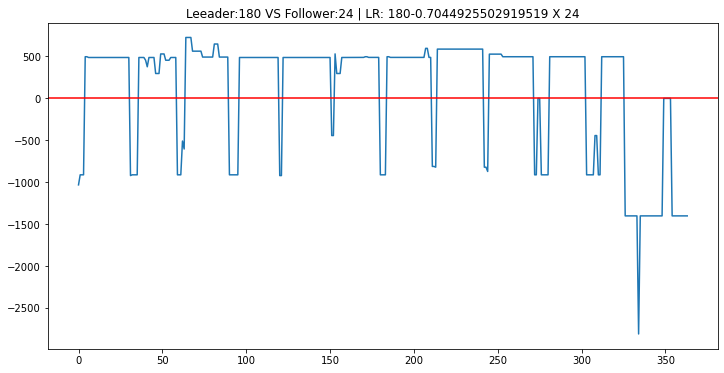

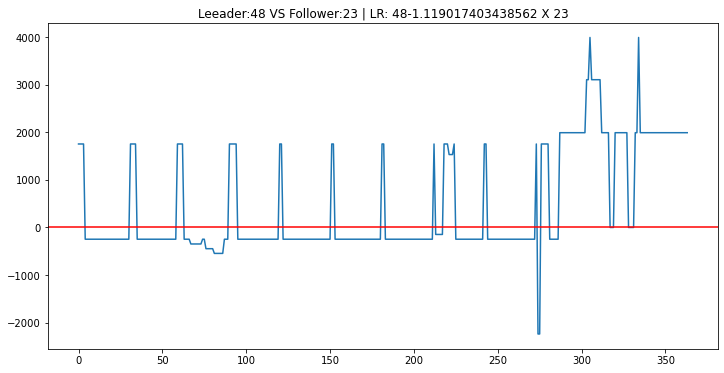

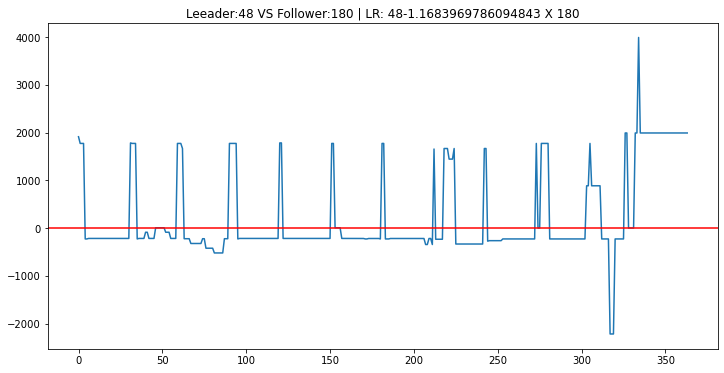

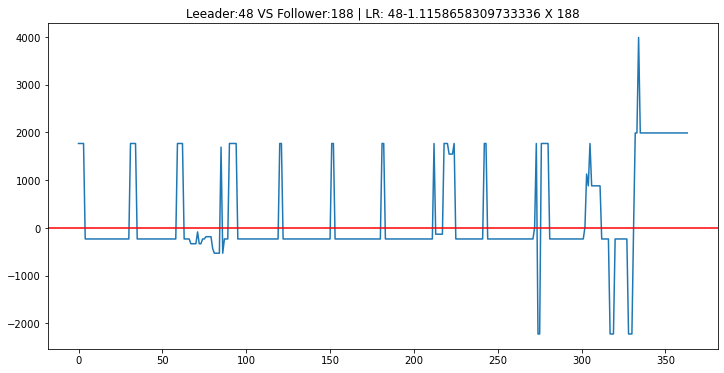

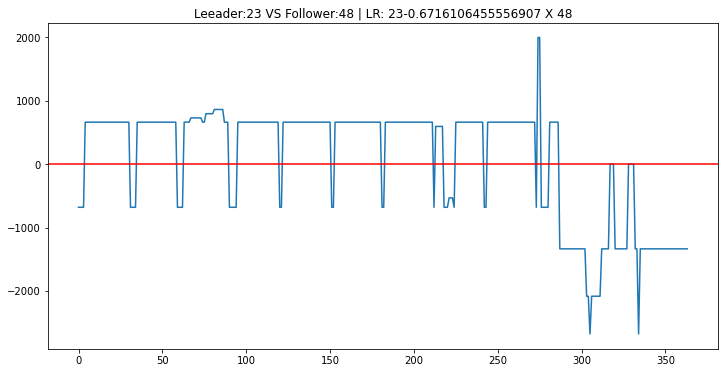

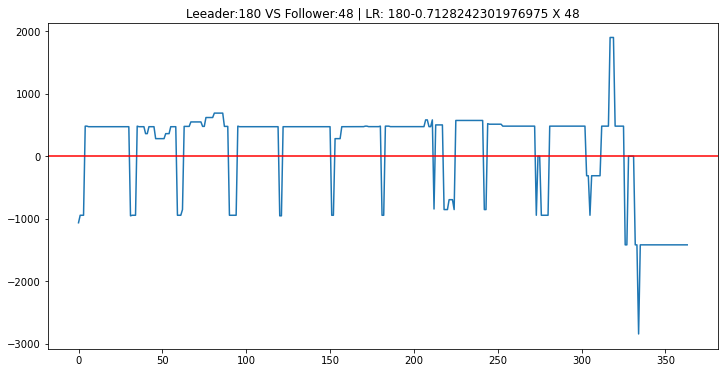

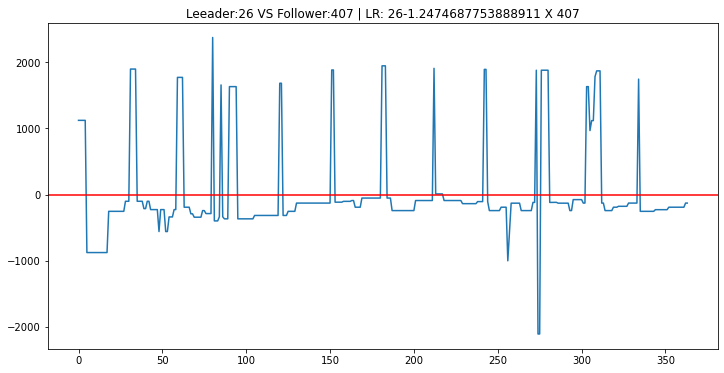

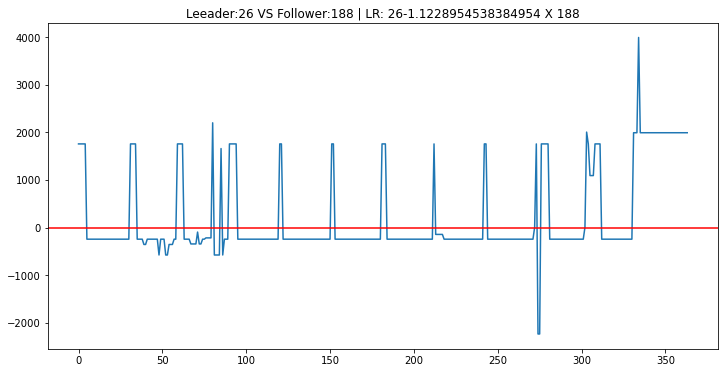

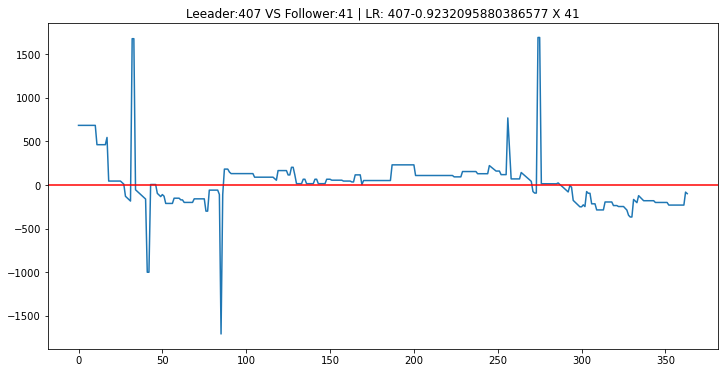

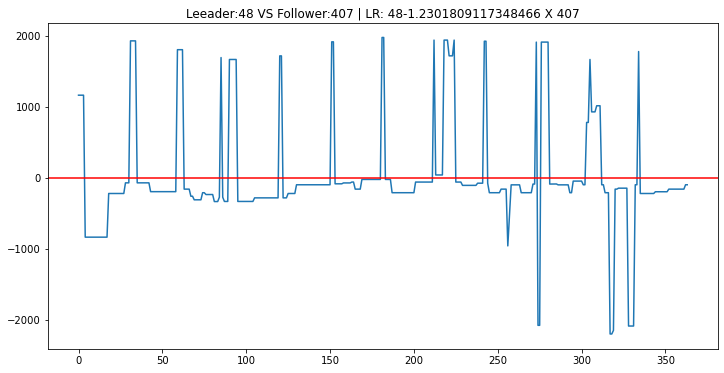

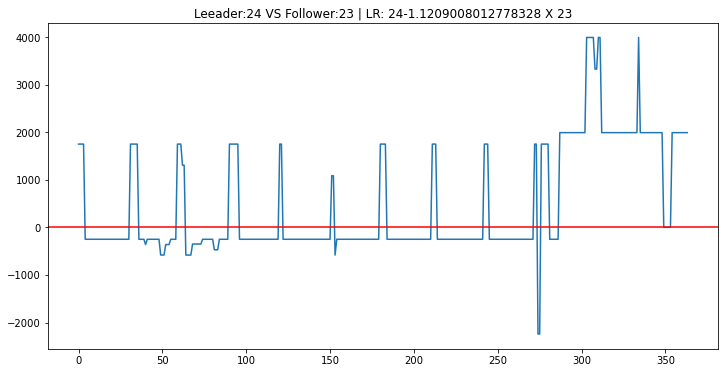

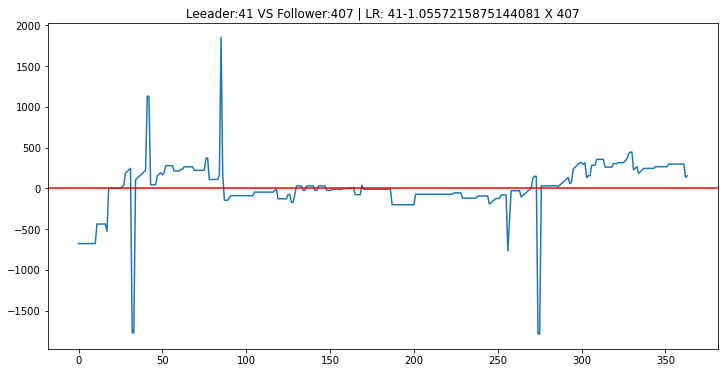

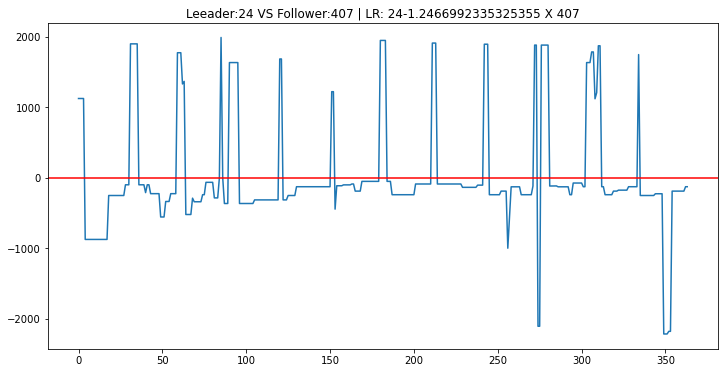

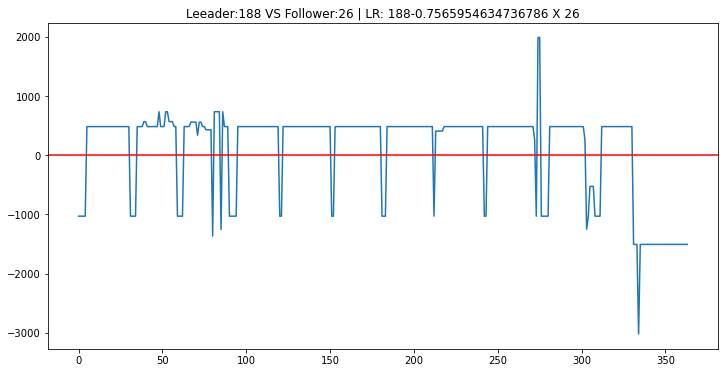

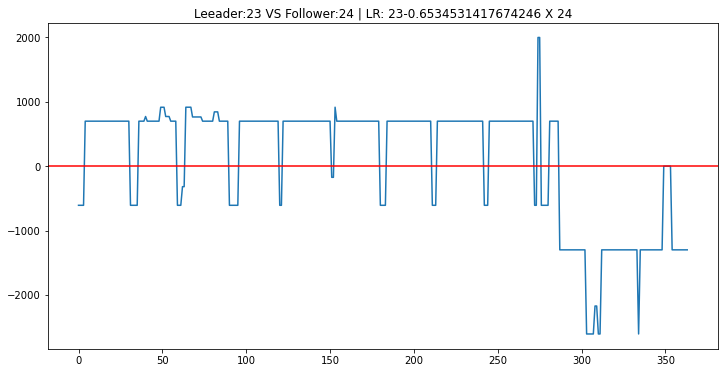

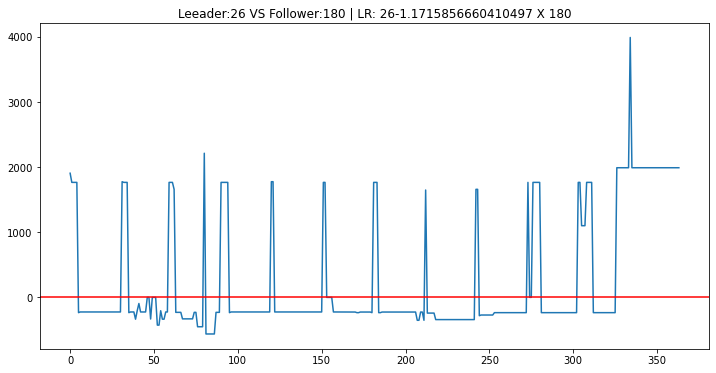

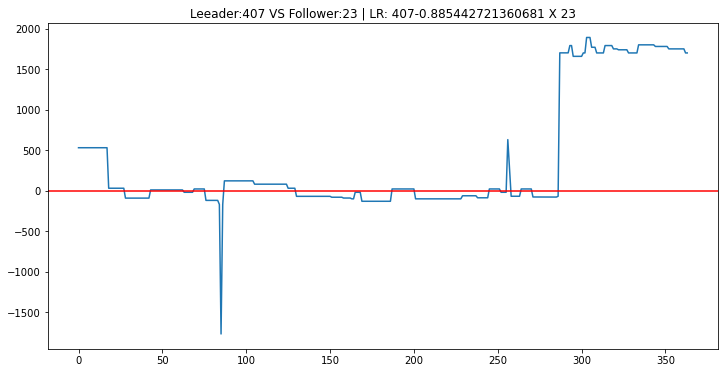

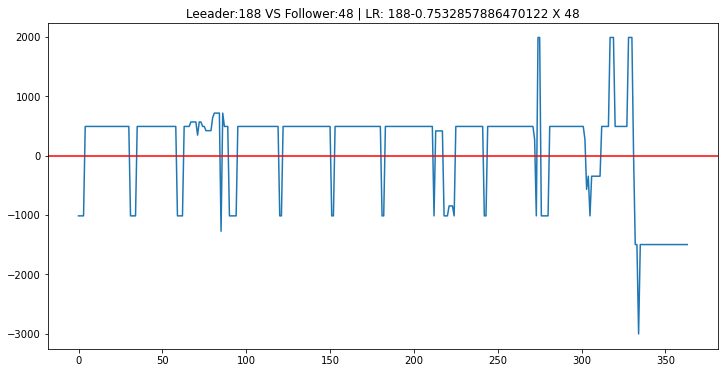

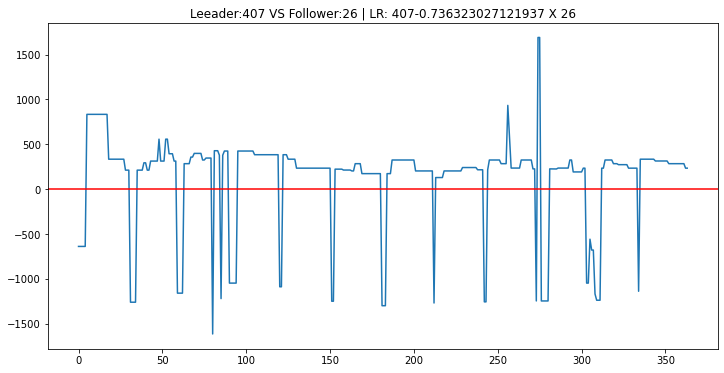

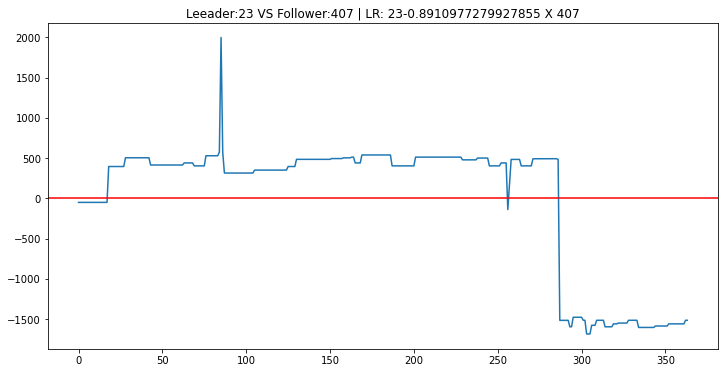

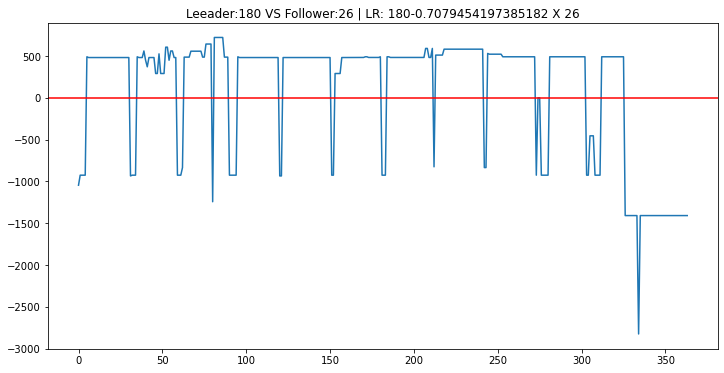

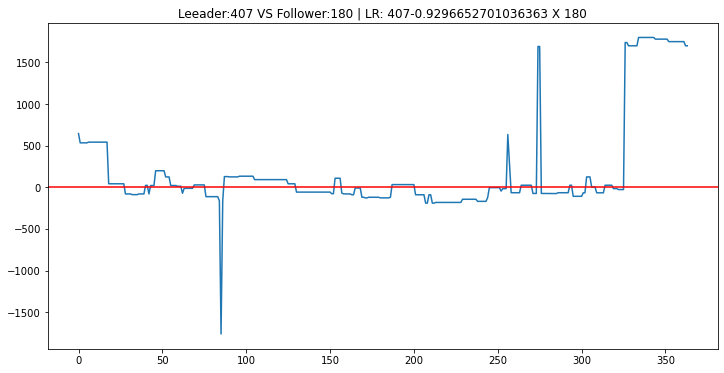

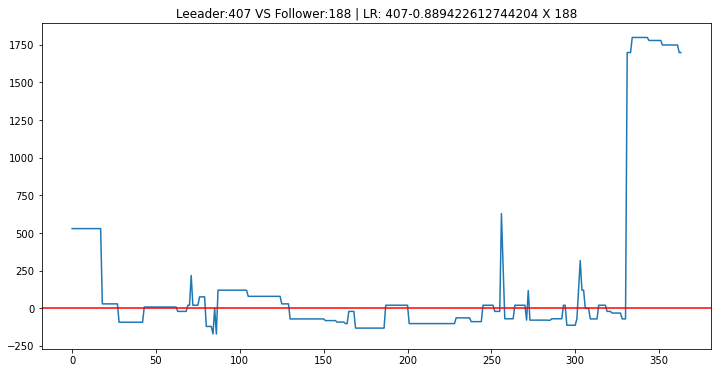

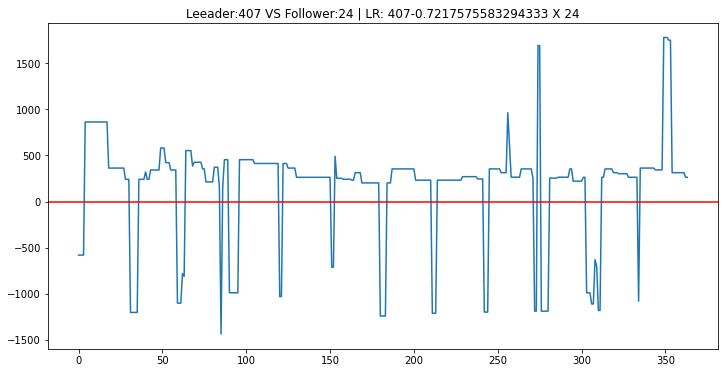

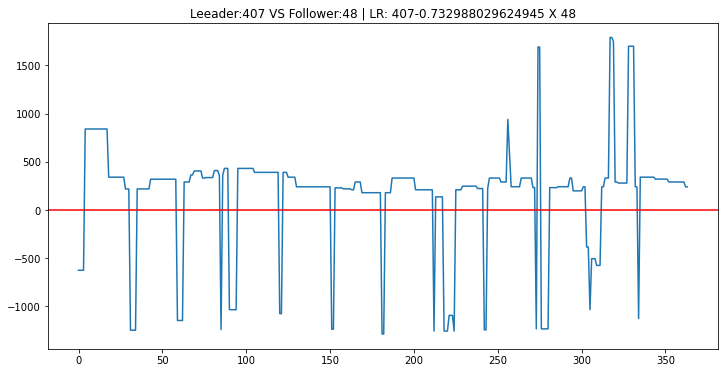

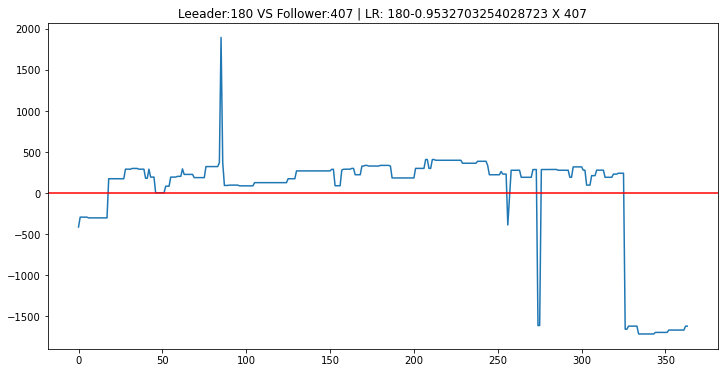

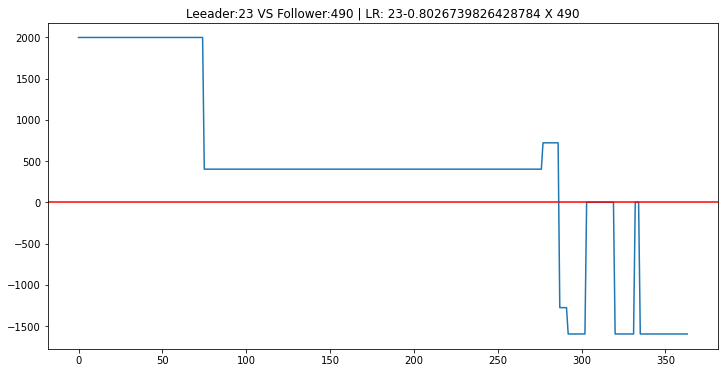

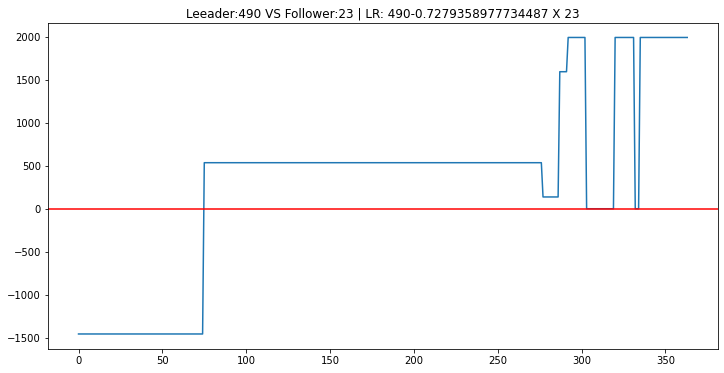

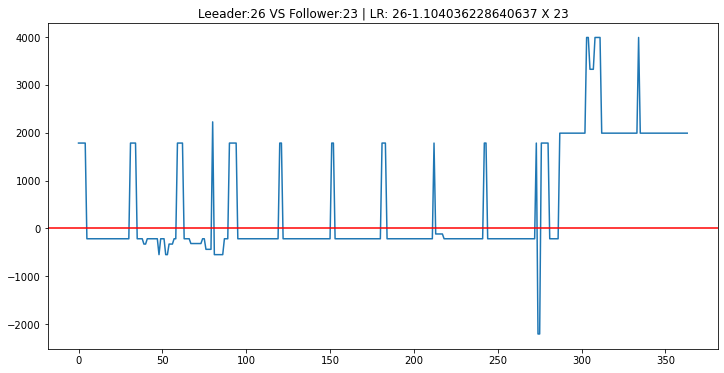

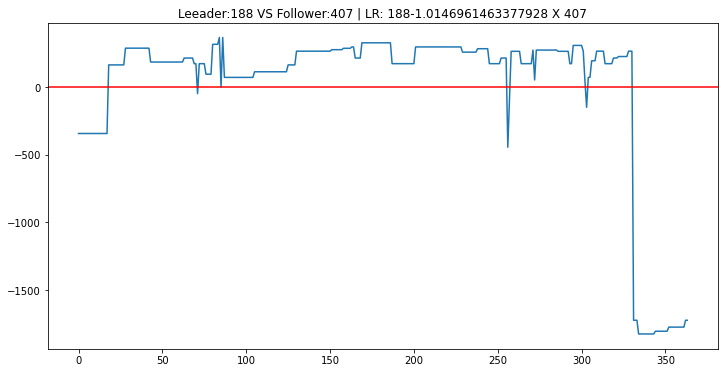

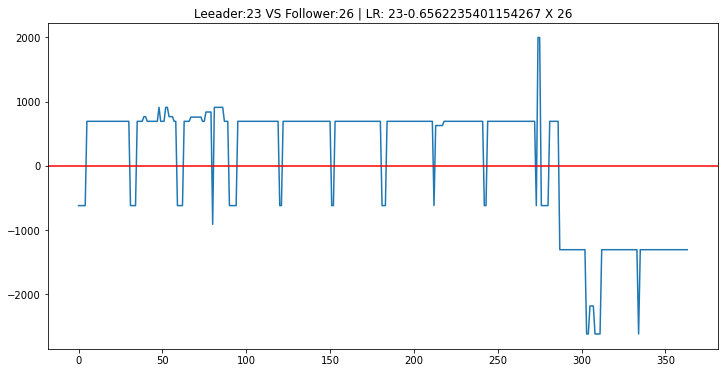

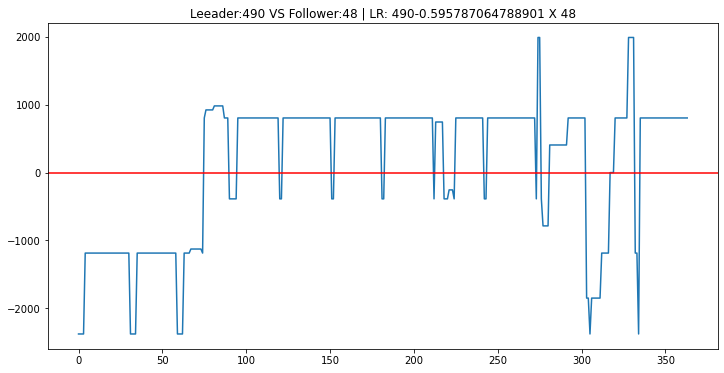

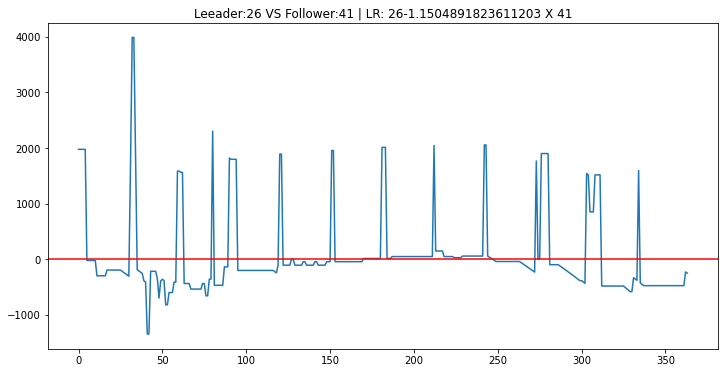

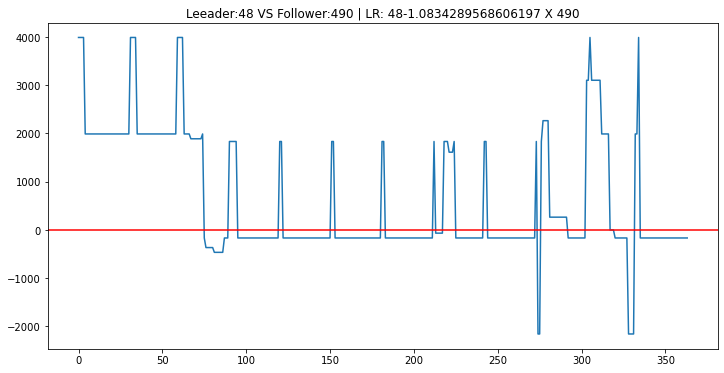

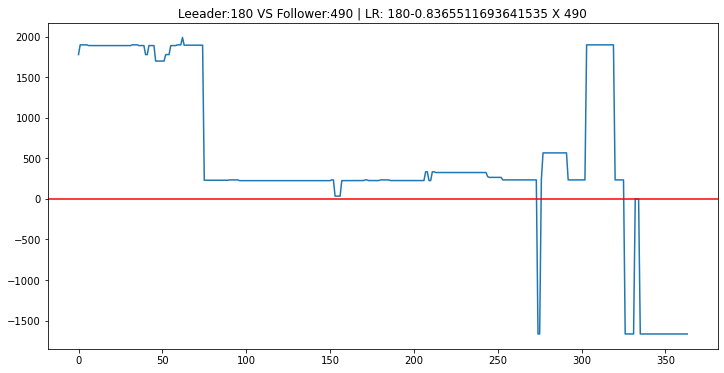

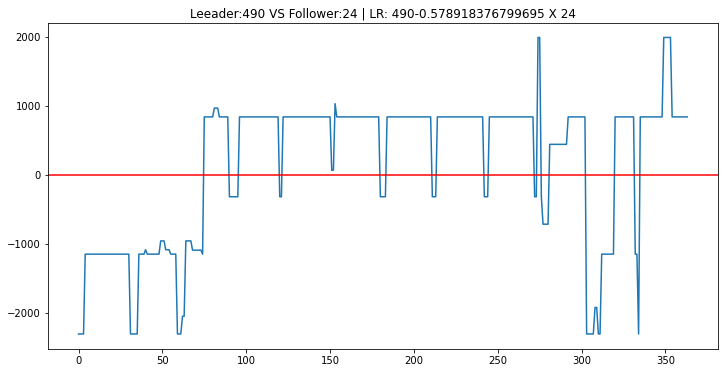

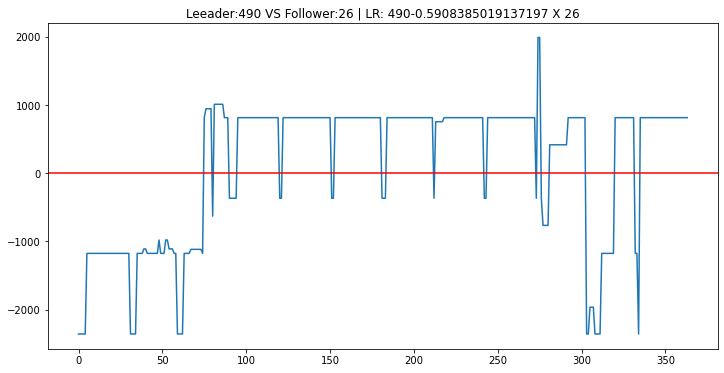

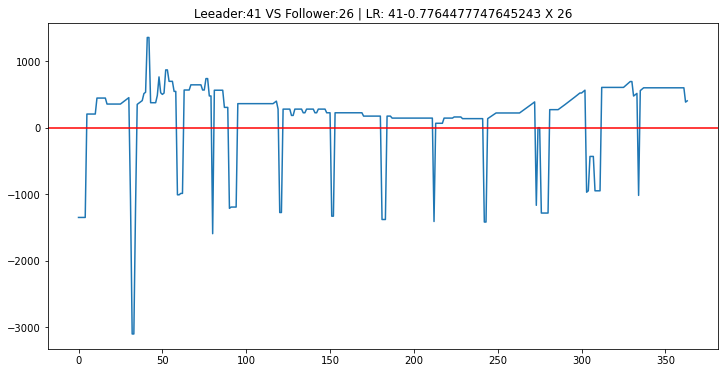

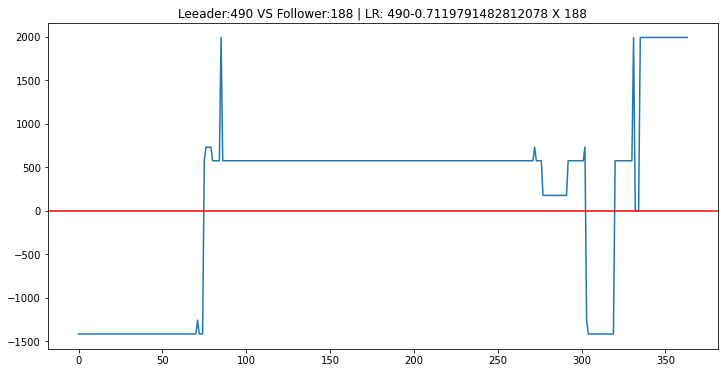

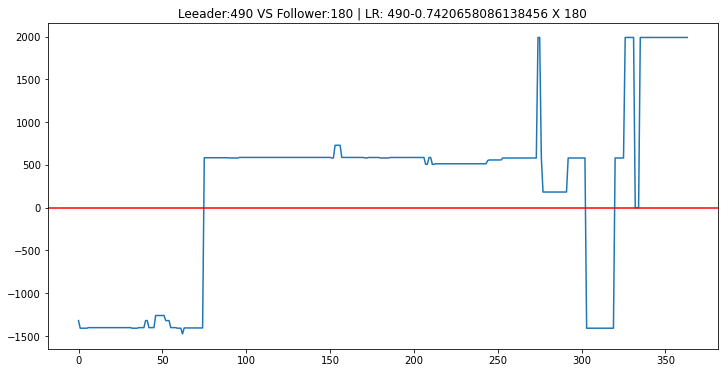

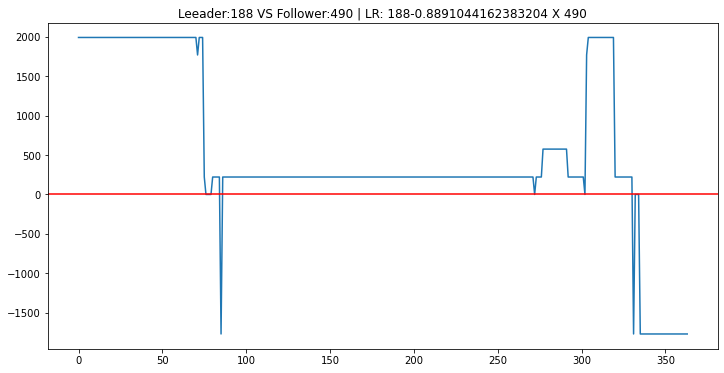

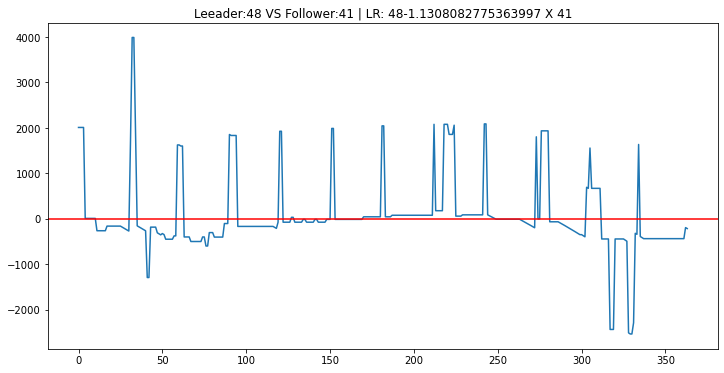

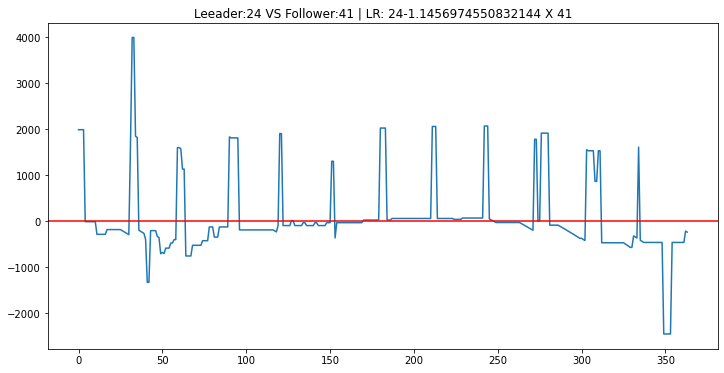

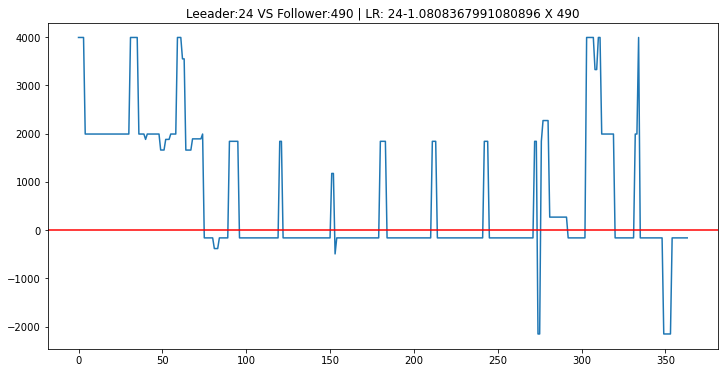

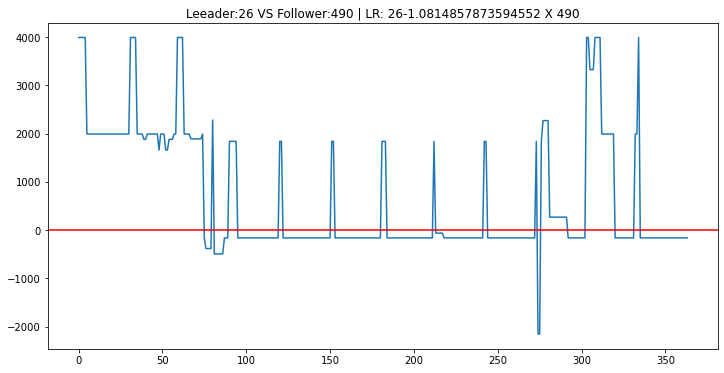

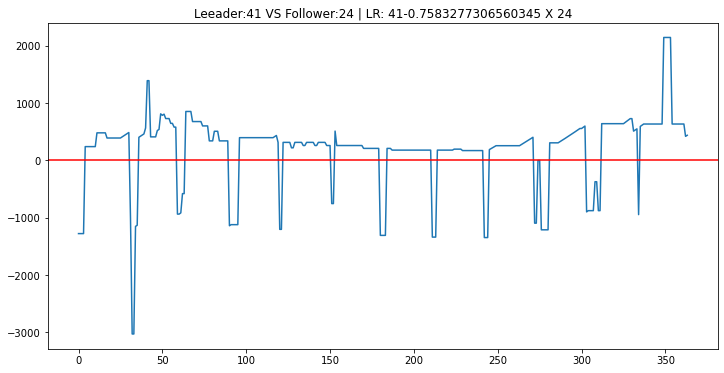

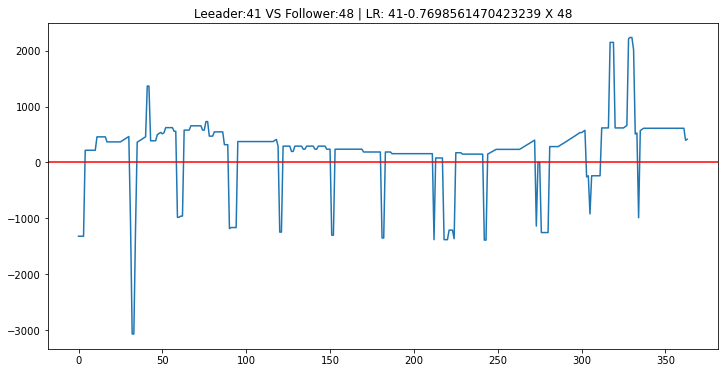

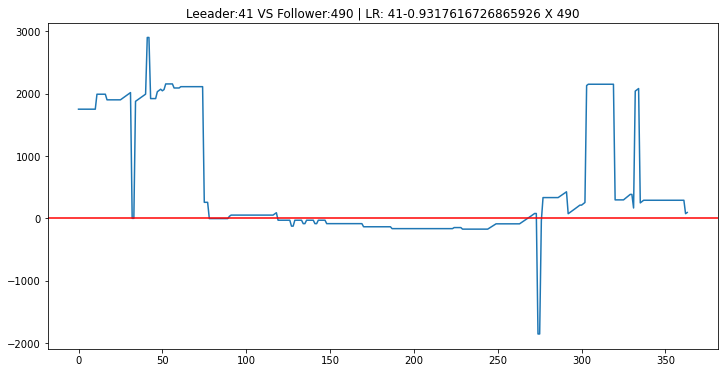

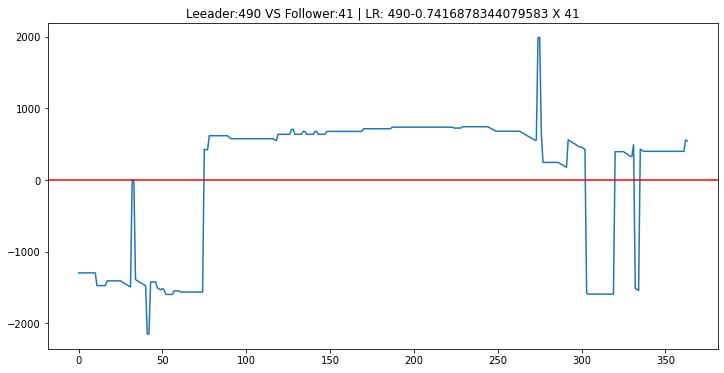

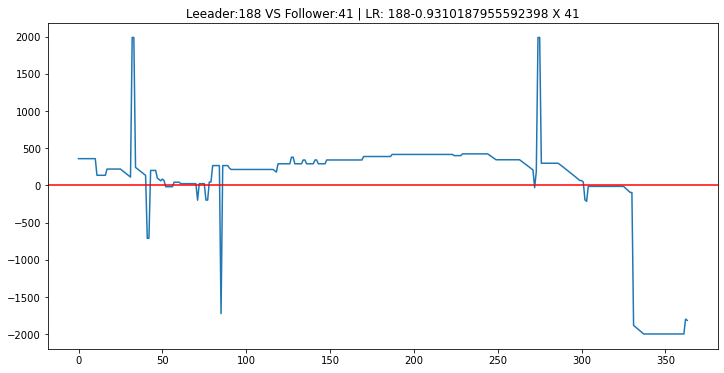

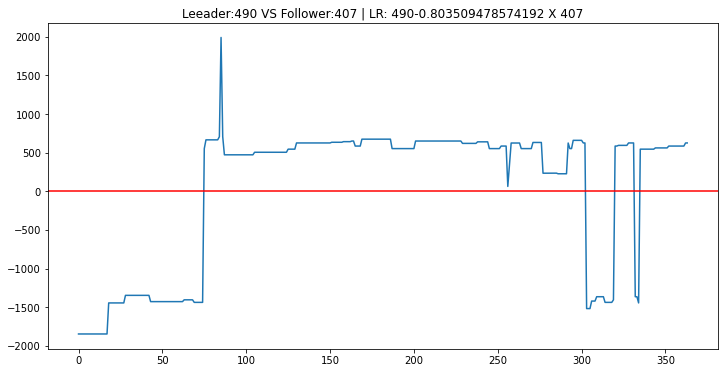

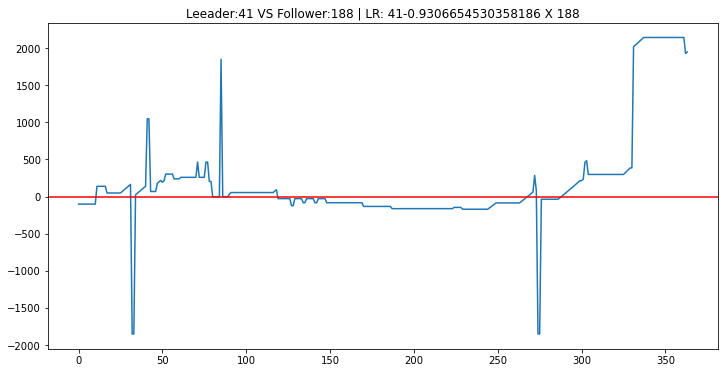

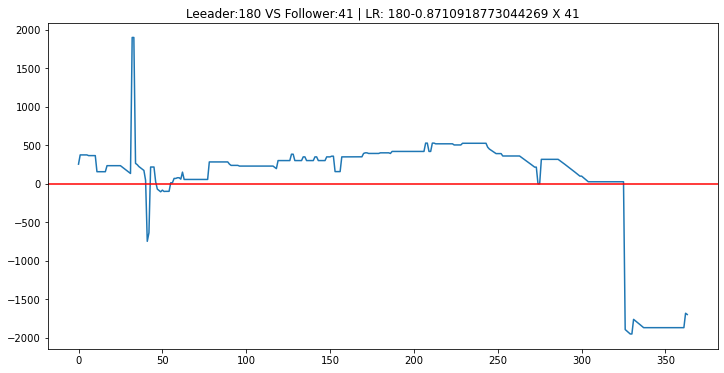

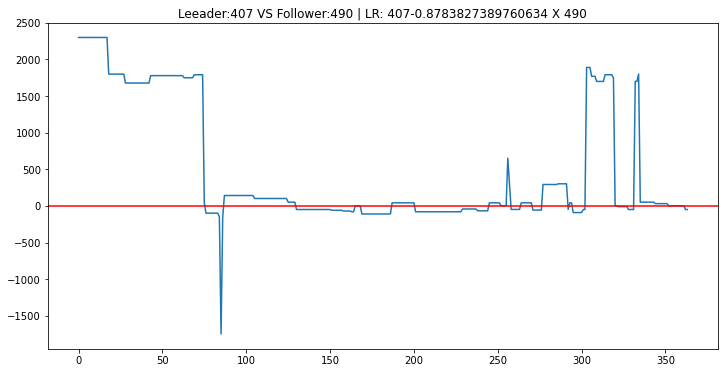

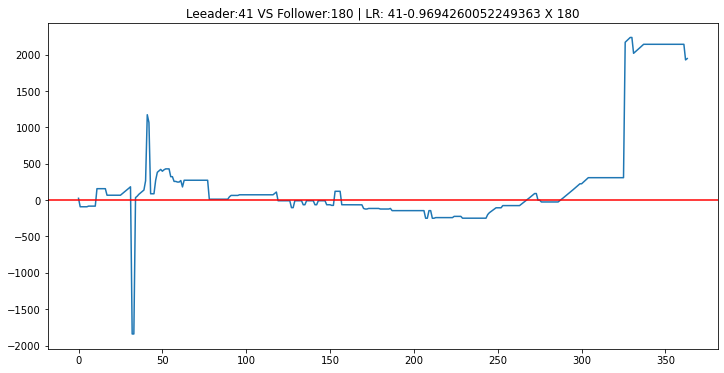

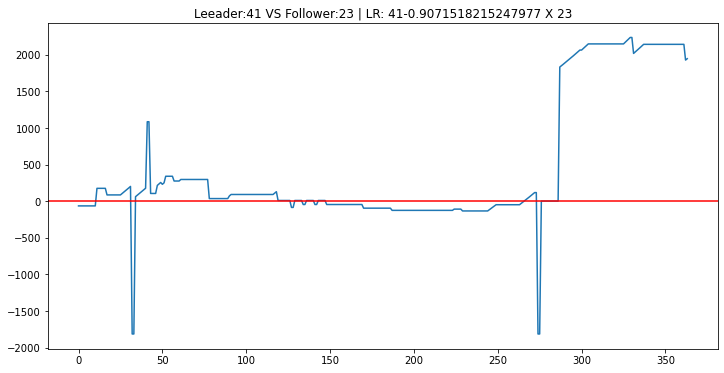

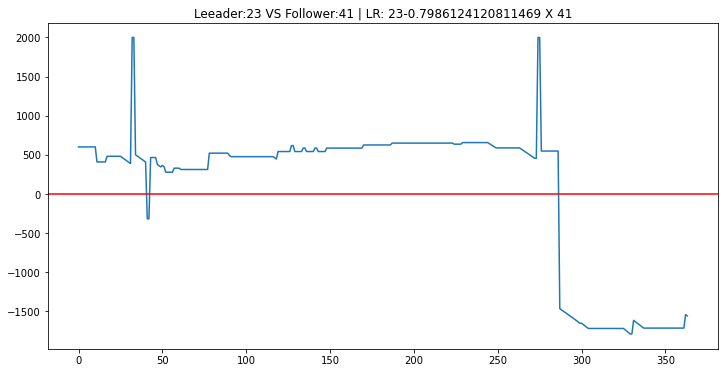

In [77]:
for i in range(sample.shape[0]):
    plt.figure(figsize=(12,6))
    plt.plot(pandasDF_shifted[sample.iloc[i]['Leader']] - pandasDF_shifted[sample.iloc[i]['Follower']]*sample.iloc[i]['Beta'])
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title(str("Leeader:"+str(sample.iloc[i]['Leader']))+" VS Follower:"+  str(sample.iloc[i]['Follower'])+" | LR: "  + str(sample.iloc[i]['Leader'])+"-" + str(sample.iloc[i]['Beta']) + " X " + str(sample.iloc[i]['Follower']))
    plt.show()